# Spatio Temporal Analysis of CHIRPS Data

# X-means sample 

In [1]:
!pip install pyclustering

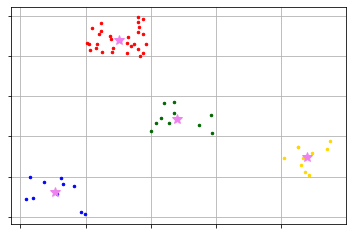

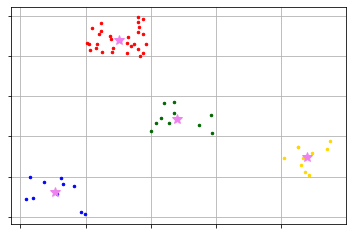

In [2]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.gmeans import gmeans

from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import SIMPLE_SAMPLES

# Read sample 'simple3' from file.
sample = read_sample(SIMPLE_SAMPLES.SAMPLE_SIMPLE3)

# Prepare initial centers - amount of initial centers defines amount of clusters from which X-Means will
# start analysis.
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(sample, amount_initial_centers).initialize()

# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 20.
xmeans_instance = xmeans(sample, initial_centers, 20)
xmeans_instance.process()

# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()

# Visualize clustering results
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, sample)
visualizer.append_cluster(centers, None, marker='*', markersize=10)
visualizer.show()

# Get SPI pentad rainfall data

In [3]:
import numpy as np
import os

path = 'data/'
image_folder = 'CHIRPS_SPI_4pentads/'
lon = np.genfromtxt( path + "AOI_longitude.csv", delimiter=',')
lat = np.genfromtxt( path + "AOI_latitude.csv", delimiter=',')
    
files_raw = np.array(os.listdir(path + image_folder))
if '.DS_Store' in files_raw:    
    files = np.delete( files_raw, np.where(files_raw == '.DS_Store')[0][0] )
else:
    files = files_raw
files = np.sort(files)
ymp = [ (f.split('_')[1][1:5],  f.split('_')[1].split('m')[1].split('p')[0] ,
            f.split('_')[1].split('m')[1].split('p')[1])  for f in files]
image_arr = np.array([ np.genfromtxt( path + image_folder + f, delimiter=',') for f in files])
# image_arr_reshaped = np.transpose(image_arr, (1,2,0))

data_dict = {'latitude': lat,
        'longitude':lon,
        'imagearray': image_arr,
        'filenames':files,
        'ymp': ymp}

In [4]:
def normalize_array(data_array, transform = None, axis = 0):
    if transform != None:
        transformed_arr = transform(data_array)
    else:
        transformed_arr = data_array
    mean = np.nanmean(transformed_arr, axis = axis)
    std = np.nanstd(transformed_arr, axis = axis)
    data_norm = (transformed_arr - mean ) / std
    if data_norm.shape != data_array.shape:
        raise (ValueError)
    return data_norm

In [5]:
def log10_zerosnan(m):
    o = np.empty_like(m)
    o[:] = np.nan
    return np.log10(m, out=o, where=(m!=0))

In [6]:
normalized_arr = normalize_array(data_dict['imagearray'],
                                  transform = log10_zerosnan)
normalized_arr[np.isnan(normalized_arr)] = 0
X = normalized_arr
# X = aggregate_yearly(data_dict)
X_2d = X.reshape((-1,X.shape[0]))

/var/folders/86/dsskgdwx0rx3sqjjl0kpv4wm0000gn/T/ipykernel_25514/421829436.py:4: RuntimeWarning: invalid value encountered in log10
  return np.log10(m, out=o, where=(m!=0))


In [7]:
data_dict['imagearray'].shape

(3000, 48, 59)

In [8]:
x_min, x_max = data_dict['longitude'].min(), data_dict['longitude'].max()
y_min, y_max = data_dict['latitude'].min(), data_dict['latitude'].max()
extent = [x_min , x_max, y_min , y_max]

# Run k-means

In [9]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

In [10]:
def prepare_data(data_dict):
    image_arr = data_dict['imagearray'].transpose(1,2,0)
    w, h, d = original_shape = tuple(image_arr.shape)
    X = np.reshape(image_arr, (w * h, d))
    return X, (w,h,d)

In [11]:
def filter_by_month(data_dict, months):
    ymp = np.array(data_dict['ymp'])[:,1].astype(int)
    selected_months = np.isin(ymp, months)
    updated_data_dict = {}
    updated_data_dict['latitude'] = data_dict['latitude']
    updated_data_dict['longitude'] = data_dict['longitude']
    updated_data_dict['imagearray'] = data_dict['imagearray'][selected_months,:,:]
    updated_data_dict['ymp'] = np.array(data_dict['ymp'])[selected_months]
    updated_data_dict['filenames'] = np.array(data_dict['filenames'])[selected_months]
    return updated_data_dict

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

spi_window = 4
for key in ['imagearray', 'filenames', 'ymp']:
    data_dict[key] = data_dict[key][spi_window:-spi_window]
    
select_months = [2,3,4,5,6,7,8,9] #Feb to Sept
data_dict = filter_by_month(data_dict, select_months)

X, shape_tuple = prepare_data(data_dict)
w,h,d = shape_tuple

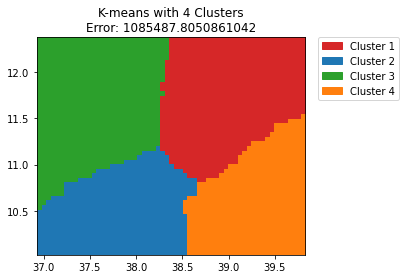

In [13]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, # Number of clusters to form
            init='k-means++', # Method for initialization: 
              # ‘k-means++’ : selects initial cluster centroids using sampling based on an empirical probability distribution of the points’ contribution to the overall inertia. This technique speeds up convergence, and is theoretically proven to be -optimal. See the description of n_init for more details.
            n_init=20, # Number of time the k-means algorithm will be run with different centroid seeds. Result is best output in terms of inertia
            max_iter=1000, # Maximum number of iterations of the k-means algorithm for a single run.
            tol=0.0001, #Relative tolerance with regards to Frobenius norm of the difference in the cluster centers of two consecutive iterations to declare convergence.
            verbose=0, # Verbosity mode
            random_state=0, 
            copy_x=True, 
            algorithm='full'# K-means algorithm to use. The classical EM-style algorithm is "full"
            )
        
kmeans.fit_predict(X)
cmap = ListedColormap(['tab:red','tab:blue','tab:green','tab:orange'])
labels = kmeans.labels_
im = plt.imshow(labels.reshape(w,h) ,
            cmap= cmap, 
            interpolation='None', extent = extent)
values = np.unique(labels)
colors = [ im.cmap(im.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label="Cluster {l}".format(l=values[i] +1) ) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.title("K-means with 4 Clusters\nError: " + str(kmeans.inertia_))
plt.show()

# Run X means

In [14]:
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(X, amount_initial_centers).initialize()

# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 20.
xmeans_instance = xmeans(X, initial_centers, tolerance=0.001)
xmeans_instance.process()

# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()

In [15]:
def plot_map2(labels):
    def get_extent(data_dict):
        x_min, x_max = data_dict['longitude'].min(), data_dict['longitude'].max()
        y_min, y_max = data_dict['latitude'].min(), data_dict['latitude'].max()
        extent = [x_min , x_max, y_min , y_max]
        return extent
    #labels = gmm.predict(X)
    im = plt.imshow(labels.reshape(w,h) , 
                interpolation='None', extent = get_extent(data_dict), cmap=plt.get_cmap('hsv'))
    # get the colors of the values, according to the 
    # colormap used by imshow
    values = np.unique(labels)
    colors = [ im.cmap(im.norm(value)) for value in values]
    # create a patch (proxy artist) for every color 
    patches = [ mpatches.Patch(color=colors[i], label="Cluster {l}".format(l=values[i] +1) ) for i in range(len(values)) ]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
    
    plt.show()

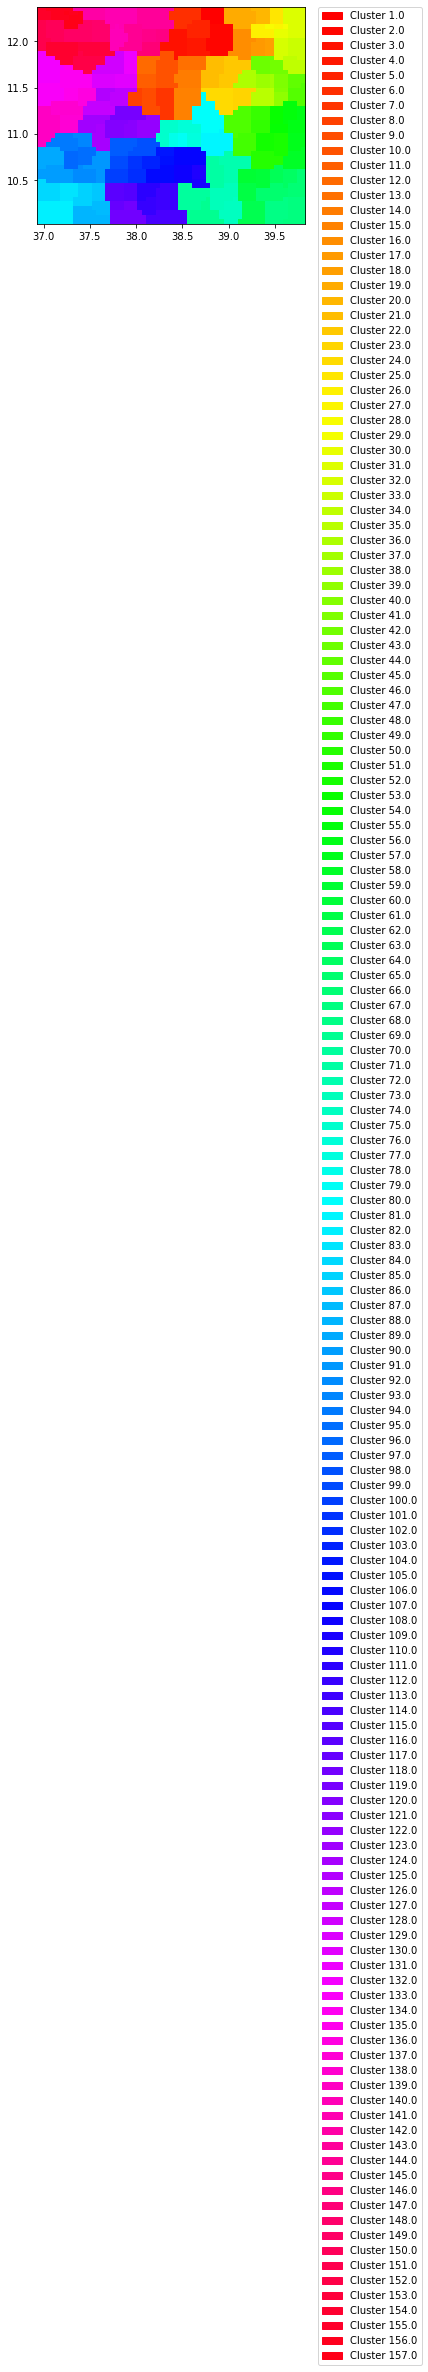

In [16]:
from pyclustering.cluster.xmeans import splitting_type

# see criteria at each split
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(X, amount_initial_centers).initialize()

# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 20.
xmeans_instance = xmeans(X, initial_centers, 1000, tolerance = 0.001)
xmeans_instance.process()

# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()
xmeans_labels = np.zeros(len(X))
for i in range(len(clusters)):
    for idx in clusters[i]:
        xmeans_labels[idx] = i
plot_map2(xmeans_labels)

0.7888277193897654


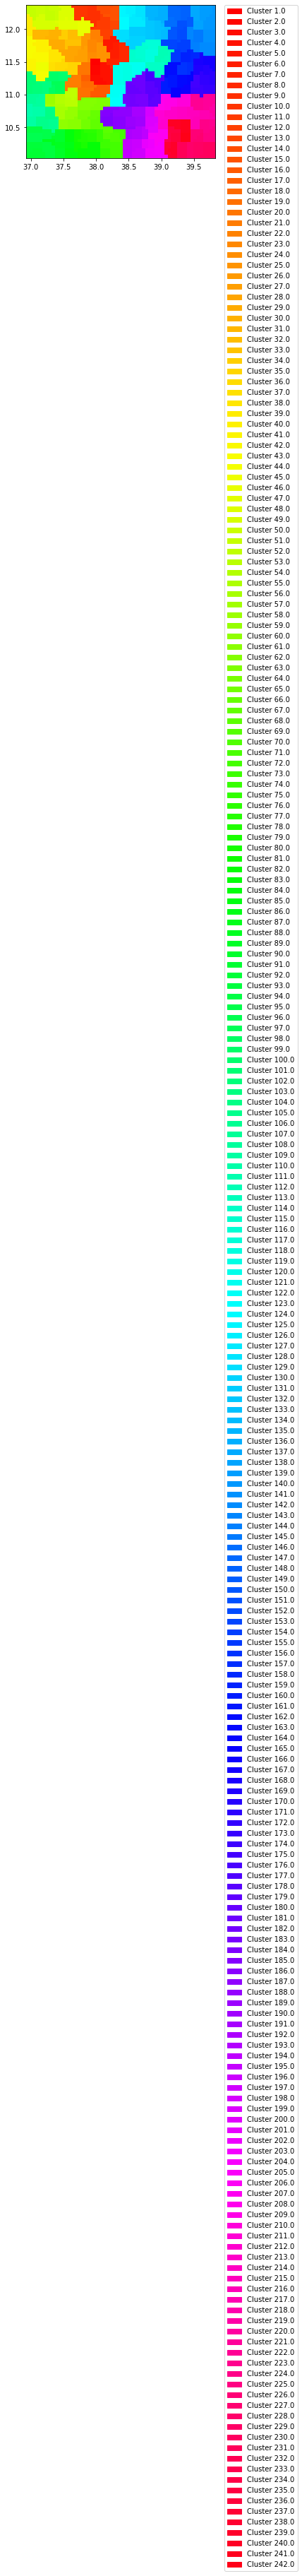

In [17]:
# run x-means on PCA
pca = PCA(n_components=20).fit(X)
print(sum(pca.explained_variance_ratio_))
X_pca = pca.transform(X)
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(X_pca, amount_initial_centers).initialize()

# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 20.
xmeans_instance = xmeans(X_pca, initial_centers, 1000, tolerance = 0.001)
xmeans_instance.process()

# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()
xmeans_labels = np.zeros(len(X_pca))
for i in range(len(clusters)):
    for idx in clusters[i]:
        xmeans_labels[idx] = i
plot_map2(xmeans_labels)

In [18]:
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(X, amount_initial_centers).initialize()

# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 20.
xmeans_instance = xmeans(X, initial_centers, 1000)
xmeans_instance.process()

# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()
xmeans_labels = np.zeros(len(X))
for i in range(len(clusters)):
    for idx in clusters[i]:
        xmeans_labels[idx] = i

# Run PCA

In [19]:
from sklearn.decomposition import PCA
n_components = 4
pca = PCA(n_components=n_components).fit(X)
evr = pca.explained_variance_ratio_

In [20]:
pca = pca.transform(X)

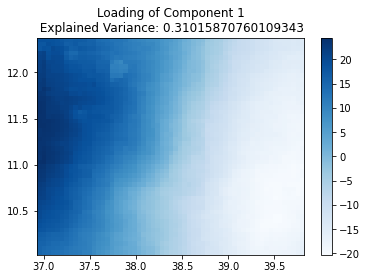

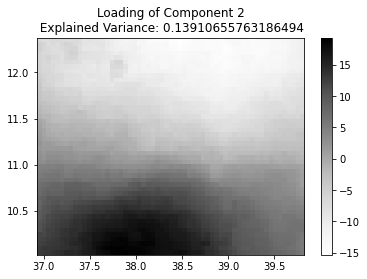

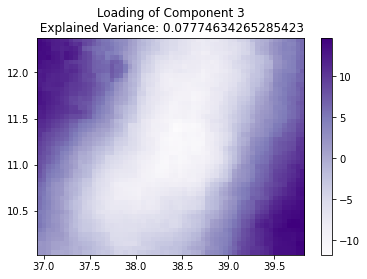

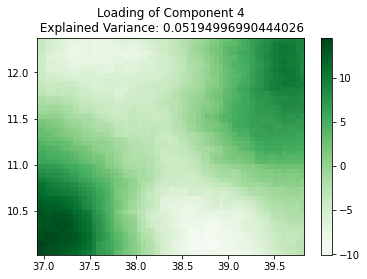

In [21]:
colors = ["Blues", "Greys", "Purples", "Greens"]
for i in range(n_components):
    labels = pca[:, i]
    im = plt.imshow(labels.reshape(w,h),
                cmap= colors[i], 
                interpolation='None', extent = extent)
    plt.title("Loading of Component " + str(i+1) + "\n Explained Variance: " + str(evr[i]))
    plt.colorbar()
    values = np.unique(labels)
    plt.show()

In [22]:
pca

array([[ 18.81085105,  -6.87022869,  13.80007976,  -3.84164932],
       [ 18.87677051,  -7.48672059,  13.18416808,  -4.49078104],
       [ 18.68080466,  -7.29829769,  12.6938275 ,  -5.34686849],
       ...,
       [-17.59232569,   7.10831509,  13.54711953,  -3.68232313],
       [-16.89523461,   6.32484316,  14.06101884,  -3.17208251],
       [-16.4661698 ,   5.5082525 ,  14.12051398,  -2.88636388]])

In [23]:
sum(evr)

0.5789615777902528

# Run G-Means

## 1. Run g-means with default settings

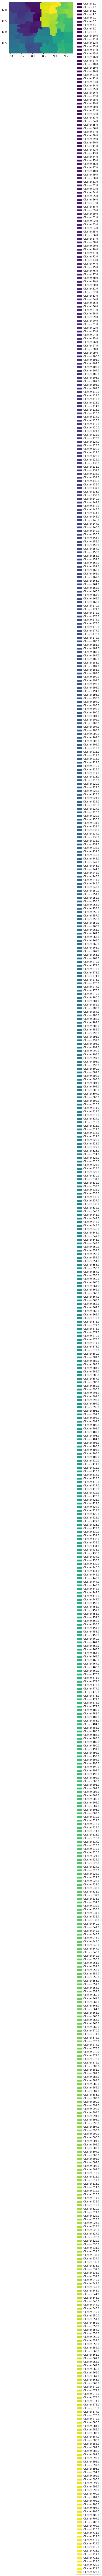

In [24]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.gmeans import gmeans

gmeans_instance = gmeans(X, repeat=5, tolerance=.0001).process()
clusters = gmeans_instance.get_clusters()
centers = gmeans_instance.get_centers()
gmeans_labels = np.zeros(len(X))
for i in range(len(clusters)):
    for idx in clusters[i]:
        gmeans_labels[idx] = i

labels = gmeans_labels
im = plt.imshow(labels.reshape(w,h) , 
            interpolation='None', extent = extent)
values = np.unique(labels)
colors = [ im.cmap(im.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label="Cluster {l}".format(l=values[i] +1) ) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.show()

## 2. Run g-means with PCA

0.7888296542212893


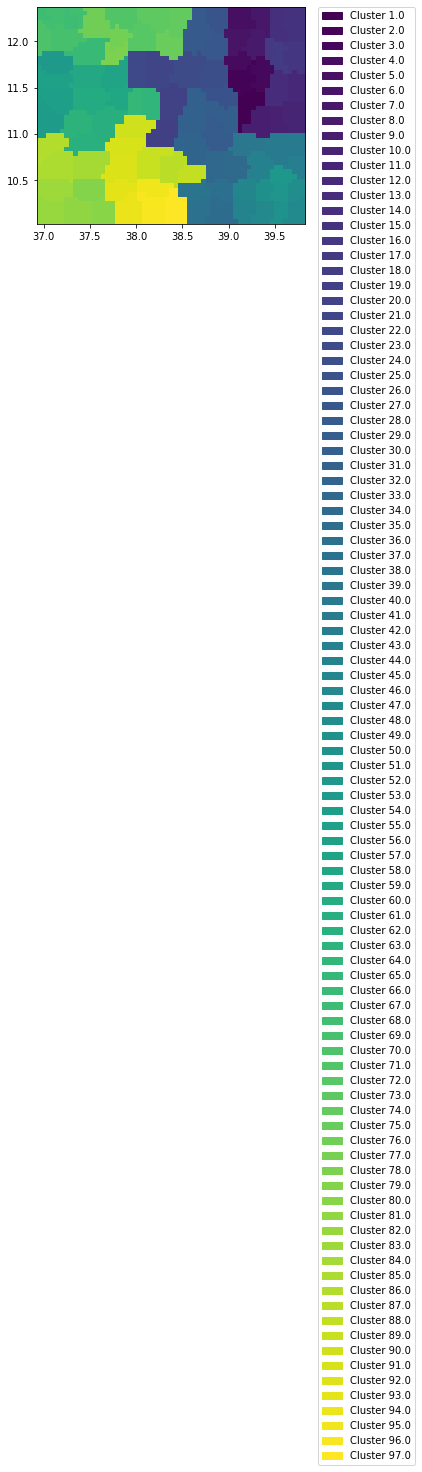

In [25]:
pca = PCA(n_components=20).fit(X)
print(sum(pca.explained_variance_ratio_))
X_pca = pca.transform(X)
gmeans_instance = gmeans(X_pca, repeat=5, tolerance=.0001).process()
clusters = gmeans_instance.get_clusters()
centers = gmeans_instance.get_centers()
gmeans_labels = np.zeros(len(X_pca))
for i in range(len(clusters)):
    for idx in clusters[i]:
        gmeans_labels[idx] = i

labels = gmeans_labels
im = plt.imshow(labels.reshape(w,h) , 
            interpolation='None', extent = extent)
values = np.unique(labels)
colors = [ im.cmap(im.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label="Cluster {l}".format(l=values[i] +1) ) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.show()

# Analysis

## 1. Run and plot PCA n-components vs. optimal k and error

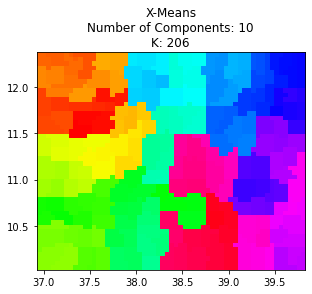

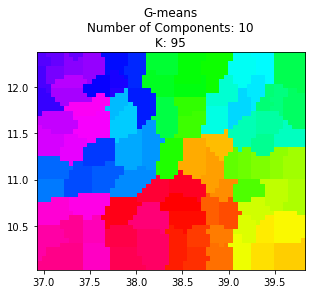

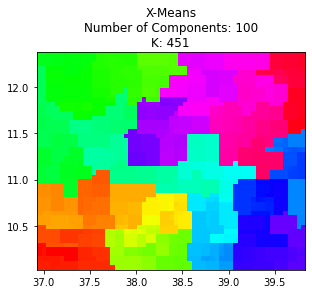

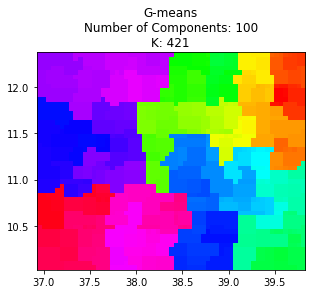

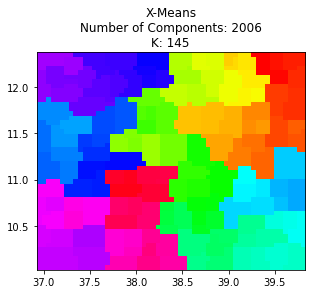

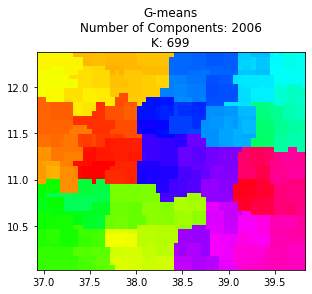

In [71]:
from sklearn.metrics import davies_bouldin_score

# find for pca=[10, 50, 100, 500, 1000, all] x-means k and error, g-means k and error
n_components = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 1000, len(X[0])]
x_means_k = []
g_means_k = []
x_means_errors = []
g_means_errors = []
for n in n_components:
    X_pca = PCA(n_components=n).fit_transform(X)
    
    # run x means (requires initial centers)
    initial_centers = kmeans_plusplus_initializer(X_pca, 2).initialize()
    xmeans_instance = xmeans(X_pca, initial_centers, 1000, tolerance = .0001).process()
    x_means_k += [len(xmeans_instance.get_centers())]
    clusters = xmeans_instance.get_clusters()

    xmeans_labels = np.zeros(len(X_pca))
    for i in range(len(clusters)):
        for idx in clusters[i]:
            xmeans_labels[idx] = i
            
    # calculate error (davies_bouldin_score)
    x_means_errors += [davies_bouldin_score(X_pca, xmeans_labels)]
    
    if n in [10, 100, 2006]:
        labels = xmeans_labels
        im = plt.imshow(labels.reshape(w,h) , 
                interpolation='None', extent = extent, cmap=plt.get_cmap('hsv'))
        plt.title("X-Means\nNumber of Components: " + str(n) + "\nK: " + str(len(xmeans_instance.get_centers())))
        values = np.unique(labels)
        colors = [ im.cmap(im.norm(value)) for value in values]
        patches = [ mpatches.Patch(color=colors[i], label="Cluster {l}".format(l=values[i] +1) ) for i in range(len(values)) ]
        plt.show()
    
    # run g means
    gmeans_instance = gmeans(X_pca, repeat=5, tolerance=.0001).process()
    g_means_k += [len(gmeans_instance.get_centers())]
    clusters = gmeans_instance.get_clusters()

    gmeans_labels = np.zeros(len(X_pca))
    for i in range(len(clusters)):
        for idx in clusters[i]:
            gmeans_labels[idx] = i
            
    # calculate error (davies_bouldin_score)
    g_means_errors += [davies_bouldin_score(X_pca, gmeans_labels)]
    
    if n in [10, 100, 2006]:
        labels = gmeans_labels
        im = plt.imshow(labels.reshape(w,h), 
                    interpolation='None', extent = extent, cmap=plt.get_cmap('hsv'))
        plt.title("G-means\nNumber of Components: " + str(n) + "\nK: " + str(len(gmeans_instance.get_centers())))
        values = np.unique(labels)
        colors = [ im.cmap(im.norm(value)) for value in values]
        patches = [ mpatches.Patch(color=colors[i], label="Cluster {l}".format(l=values[i] +1) ) for i in range(len(values)) ]
        plt.show()

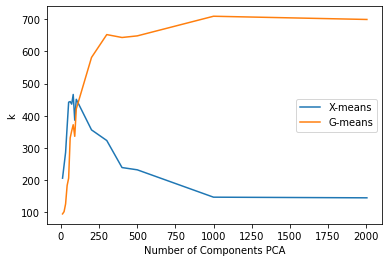

In [72]:
plt.plot(n_components, x_means_k, label="X-means")
plt.plot(n_components, g_means_k, label="G-means")
plt.xlabel("Number of Components PCA")
plt.ylabel("k")
plt.legend()
plt.show()

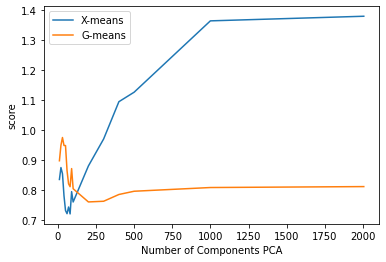

In [73]:
plt.plot(n_components, x_means_errors, label="X-means")
plt.plot(n_components, g_means_errors, label="G-means")
plt.xlabel("Number of Components PCA")
plt.ylabel("score")
plt.legend()
plt.show()

In [74]:
print([1/x for x in x_means_errors])

[1.1956786469321725, 1.1415429753818458, 1.1690724936167984, 1.278768412731618, 1.3644202655213546, 1.3843114914327224, 1.3429084994712979, 1.3857595715357114, 1.256588492676528, 1.3134774751414666, 1.1347056687459907, 1.0295407762223077, 0.9129042212986044, 0.8872660650215456, 0.732785350181589, 0.7246191429949181]


In [75]:
print(g_means_errors)

[0.8986695013223707, 0.950370983296599, 0.9761200981334992, 0.9495764290387709, 0.9493017617623668, 0.8656671624017145, 0.8217891078125169, 0.8123642346952469, 0.8726269291654066, 0.8054769726284089, 0.7615344230518887, 0.7638159582594598, 0.7863253281718613, 0.7971536703740376, 0.8095276154269648, 0.8126311307132993]


In [76]:
len(X[0])

2006

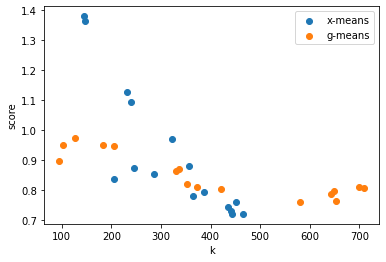

In [97]:
plt.scatter(x_means_k, x_means_errors, label="x-means")
plt.scatter(g_means_k, g_means_errors, label="g-means")
plt.xlabel("k")
plt.ylabel("score")
plt.legend()
plt.show()

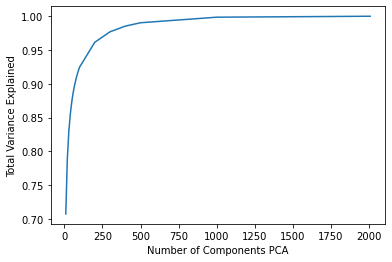

In [78]:
n_components = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 1000, len(X[0])]
explained_var = []
for n in n_components:
    pca = PCA(n_components=n).fit(X)
    explained_var.append(sum(pca.explained_variance_ratio_))
plt.plot(n_components, explained_var)
plt.xlabel("Number of Components PCA")
plt.ylabel("Total Variance Explained")
plt.show()

## 2. Get some more stats

In [79]:
min(x_means_k)

145

In [80]:
max(x_means_k)

466

In [81]:
min(g_means_k)

95

In [82]:
max(g_means_k)

709

In [83]:
len(g_means_k)

16

In [84]:
len(X)

2832

In [85]:
explained_var[-2]

0.9985986902409788

In [89]:
n_components[np.argmin(x_means_errors)]

80

In [90]:
n_components[np.argmin(g_means_errors)]

200

In [91]:
x_means_k[np.argmin(x_means_errors)]

466

In [92]:
g_means_k[np.argmin(g_means_errors)]

581

In [93]:
min(x_means_errors)

0.7216259014482511

In [94]:
min(g_means_errors)

0.7615344230518887

In [96]:
max(g_means_k)

709